In [87]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
from PIL import Image
import numpy as np
import cupy as cp
import time
import scipy

from skimage.morphology import binary_dilation
from scipy.optimize import minimize

from scipy import ndimage
from scipy import interpolate

from skimage.morphology import skeletonize, opening, closing, erosion, dilation, disk
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import convex_hull_image
from skimage.restoration import inpaint
from skimage import feature

from scipy.ndimage import gaussian_filter

import random
random.seed(10)

## GPU info

In [88]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun 30 12:18:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   25C    P0    58W / 400W |    569MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                    0 |
| N/A   

# HIO

In [221]:
def proj_M_gpu( x, data ):

    #'''
    fft  = cp.fft.fftn(x)
    fabs = cp.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    result = cp.fft.ifftn( result )
        
    return result
    #'''

    '''
    fft    = cp.fft.fftn( x )
    phi    = cp.angle( fft )
    result = data * cp.exp(1j * phi)
    diff =  cp.abs(fft) - data
    adiff = cp.abs(diff)

    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]

    tol = 1e-5 #jump@

    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cp.fft.ifftn( result )

    return result
    '''

    '''
    fft    = cp.fft.fftn( x )
    phi    = cp.angle(  fft  )
    result = data * cp.exp(1j * phi)

    #result[(data<0)] =  fft[(data<0)]

    #result[(data>=0)] = fft[(data>=0) ] * ( data[(data>=0)] / ( numpy.maximum( numpy.abs(fft)[(data>=0)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cp.fft.ifftn( result )

    #result = cp.fft.ifftn(result)
    #result
    #result[ data < 0] = -1

    return result
    '''


def ref_M( x, data ):
    proj = proj_M_gpu( x, data)
    result = 2 * proj - cp.identity(x.shape[0])
    return result

def ref_S(x, supp ):
    proj = proj_S( x, supp )
    result = 2 * proj - cp.identity(x.shape[0])
    return result


def projection_M_gpu( x, data ):
    return proj_M_gpu(x, data)

def projection_S ( x, supp ):
    y = x * supp
#     y[y.real < 0] = 0.0
#     y[y.imag > 0] = 0

    real = x.real
#     real[x.real < 0] = 0.0 
    
    imag = x.imag
#     imag[imag > 0] = 0
    
    y = real + 1j*imag
    return y * supp

def projection_N ( x, supp ):
    #y = numpy.copy(x)
    #y.imag = 0
    #return y

    y    = np.copy(x.real)
    mask = (y < 0)
    y[ mask ] = 0
    return y * supp



def HIO( initial, measure, support, niterations, beta, dev, threshold):

    shrinkWrapSubIter = niterations[1]
    gniteration       = niterations[0]

    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    cp.cuda.Device(dev).use()

    with cp.cuda.Device(dev):

        dsupport = cp.array(support)
        smeasure = cp.array( measure )
        x        = cp.array( initial )
        csupport = cp.array( 1-support )
        xerror   = cp.array( initial )

        iteration = 0
        sigma = 6
        initialbeta = beta

        while ( iteration < gniteration ):
            
            if (iteration % 2000 == 0):
                xerror = np.copy(x)

            y = projection_M_gpu( x, smeasure )
            x = projection_S( y, dsupport ) + projection_S( x - beta * y,  1-dsupport )

            if iteration % shrinkWrapSubIter == 0 and iteration > 0:
                z = cp.array( gaussian_filter( cp.abs(x).get(), sigma) )
                dsupport = z > ( threshold/100. ) * z.max()
                sigma = 0.99 * sigma

                beta = initialbeta + (1 - initialbeta)*(1 - np.exp(-(iteration/7)**3))
                
                if (iteration > 10000):
                    x[np.abs(x) < 0.01] = 0+1j*0
                
                if (iteration > 2000):
                    real = x.real
                    real[x.real < 0] = 0.0 

                    imag = x.imag
                    imag[imag > 0] = 0.0

                    x = real + 1j*imag
            
            if (iteration % 2000 == 0 ):
                res = x.get()
                
                plt.figure(figsize = (5,5))
                plt.imshow(np.abs(res[1*res.shape[0]//3:2*res.shape[0]//3, res.shape[1]//3:2*res.shape[1]//3]))
                plt.colorbar()
                plt.show()
                
                plt.figure(figsize = (5,5))
                plt.imshow(dsupport.get())
                plt.colorbar()
                plt.show()
                
                print(iteration, np.linalg.norm(xerror -x))
                
                
            iteration += 1

    output = x.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output



# wavefront = propagate_beam(wavefront, object_pixel_size, wavelength,+distance) # propagate
def propagate_beam(wavefront, dx, wavelength,distance,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    from cupy.fft import fft2, fftshift, ifftshift, ifft2

    ysize, xsize = wavefront.shape
    
    x_array = cp.linspace(-xsize/2,xsize/2-1,xsize)
    y_array = cp.linspace(-ysize/2,ysize/2-1,ysize)
    
    fx = x_array/(xsize)
    fy = y_array/(ysize)
    
    FX,FY = cp.meshgrid(fx,fy)

    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    elif propagator == 'fresnel':
        # % Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # % multiply by phase-shift and inverse transform 
        a = cp.exp(-1j*cp.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output


def propagation_fourier(x,inverse=False):
    if inverse == False:
        return cp.fft.fftshift(cp.fft.fft2(x))
    else:
        return cp.fft.ifft2(cp.fft.fftshift(x))
    
def projection_F_space(fft, data):
    fabs = cp.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    # result = cp.fft.ifftn( result )
    return result

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def update_wave_upstream_modulator(modulator,wave_upstream_modulator,revised_wave_downstram_modulator,wave_downstream_modulator,alpha=1):
    return wave_upstream_modulator + alpha*np.conj(modulator)*(revised_wave_downstram_modulator-wave_downstream_modulator)/np.max(np.abs(modulator)**2)

(<matplotlib.image.AxesImage at 0x7fa5bf4b7400>, Text(0.5, 1.0, 'Measurement'))

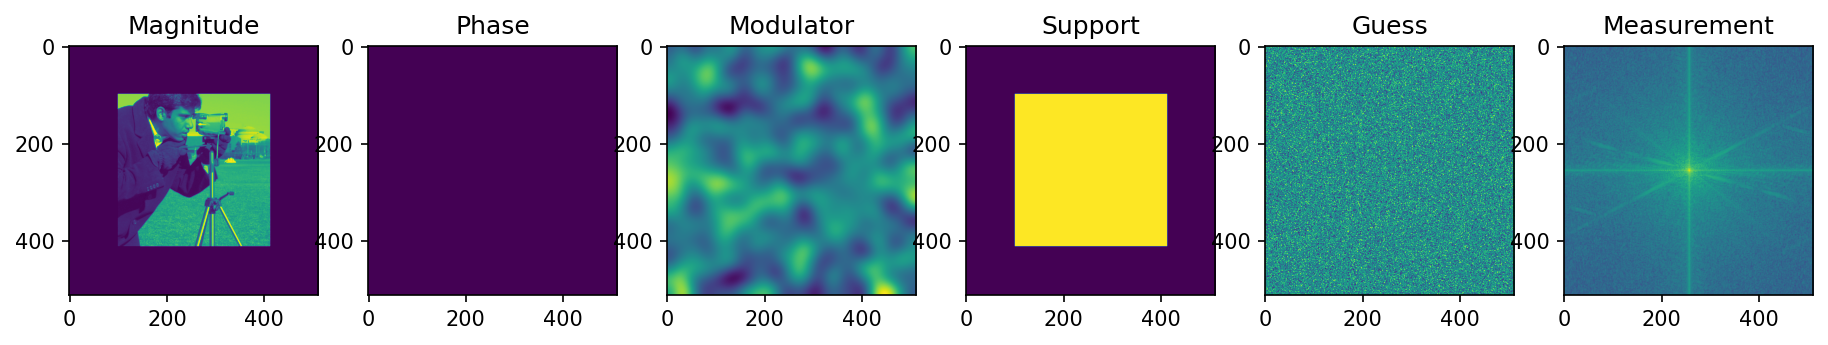

In [228]:
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
detector_distance = 10 # meters
modulator_distance = 1e-1 # meters
energy = 3 # keV
wavelength = planck * speed_of_light / energy # meters
detector_pixel = 55e-6 # meters


path1 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/gravel512.npy'
path2 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/camera512.npy'

phase = np.array( np.load(path1)) 
magnitude = np.array( np.load(path2))

n_of_pixels = magnitude.shape[0]
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,detector_distance)


modulator = 10*(2*np.pi*np.random.rand(*magnitude.shape) - np.pi)
modulator = np.exp(1j*scipy.ndimage.gaussian_filter(modulator, 20))
    
N = 50
mask = np.zeros_like(phase)
mask[2*N:-2*N,2*N:-2*N] = 1
    
phase = phase*mask
magnitude = magnitude*mask

# support = np.zeros_like(phase)
# support[N:-N,N:-N] = 1
support = mask

phase = np.pi*phase/np.max(phase)
phase = np.ones_like(phase)
magnitude = magnitude/np.max(magnitude)
model_object = np.abs(magnitude)*np.exp(1j*phase)

wave_at_detector = np.fft.fftshift(np.fft.fftn(model_object))
measurement = np.abs(wave_at_detector)

initial_guess = np.random.rand(*magnitude.shape)
# initial_guess = np.ones_like(model_object)

propagated_support = propagate_beam(support, object_pixel_size, wavelength,modulator_distance,propagator='fresnel').get()
propagated_support = np.abs(propagated_support)

fig, ax = plt.subplots(1,6,figsize=(15,5),dpi=150)
ax[0].imshow(magnitude), ax[0].set_title('Magnitude')
ax[1].imshow(phase), ax[1].set_title('Phase')
ax[2].imshow(np.angle(modulator)), ax[2].set_title('Modulator')
ax[3].imshow(support), ax[3].set_title('Support')
# ax[4].imshow(propagated_support), ax[4].set_title('Propagation')
ax[4].imshow(np.abs(initial_guess)), ax[4].set_title('Guess')
ax[5].imshow(measurement,norm=LogNorm()), ax[5].set_title('Measurement')



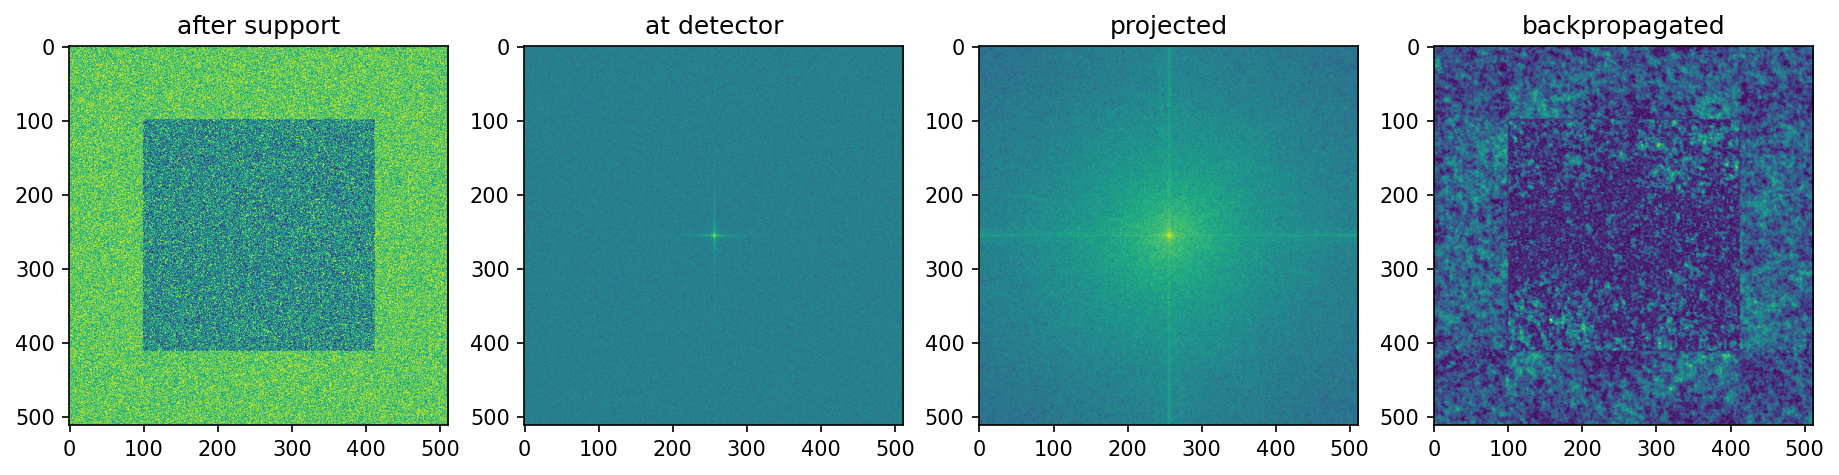

Done


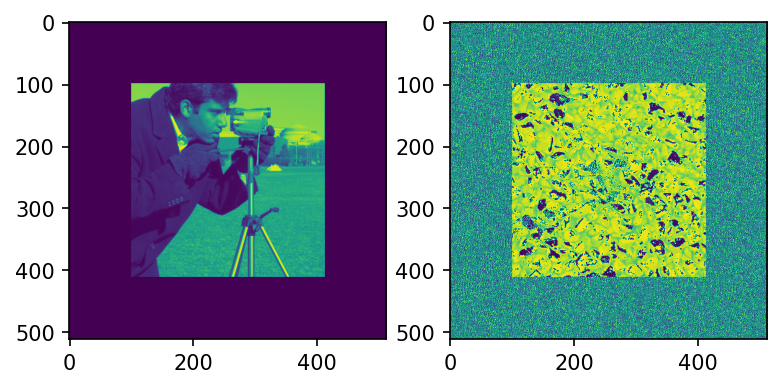

In [226]:
def CMI(initial_guess, measurement, modulator, support, iterations, pixel_size, wavelength,modulator_distance, beta=0.5, alpha=1,dev = 0):

    N_update = 40
    
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    cp.cuda.Device(dev).use()

    with cp.cuda.Device(dev):

        support     = cp.array(support)
        modulator     = cp.array(modulator)
        measurement = cp.array( measurement )
        y           = cp.array( initial_guess )
        csupport    = cp.array( 1-support )

        wave_after_support_constraint = np.ones_like(y)
        
        notCMI = True
        iteration = 0
        while ( iteration < iterations ):
            
            if iteration % 1000 == 0: print(iteration)
            
            if iteration < iterations*0.95:
                wave_after_support_constraint = projection_S( y, support ) + projection_S( wave_after_support_constraint - beta * y,  1-support ) 
            else:
                wave_after_support_constraint = projection_S( y, support )
            
            # wave_upstream_modulator = propagate_beam(wave_after_support_constraint, pixel_size, wavelength,modulator_distance,propagator='fresnel')
                                      
            # wave_downstream_modulator = wave_upstream_modulator*modulator
            
            if notCMI:
                wave_downstream_modulator = wave_after_support_constraint
            
            # if iteration % N_update == 0: # step IV of algorithm in the paper
                # previous_wave_downstream_modulator = wave_downstream_modulator
            
            # wave_at_detector = propagation_fourier(2*wave_downstream_modulator-previous_wave_downstream_modulator)
            wave_at_detector = propagation_fourier(wave_downstream_modulator)
                        
            projected_wave_at_detector = projection_F_space( wave_at_detector, measurement ) # different in the paper: downsampling
            
            revised_wave_downstram_modulator = propagation_fourier(projected_wave_at_detector,inverse=True) #- (wave_downstream_modulator - previous_wave_downstream_modulator)
            
            # previous_wave_downstream_modulator = wave_downstream_modulator # save for next iteration

            # revised_wave_upstream_modulator = update_wave_upstream_modulator(modulator,wave_upstream_modulator,revised_wave_downstram_modulator,wave_downstream_modulator,alpha) 

            if notCMI:
                y = revised_wave_downstram_modulator
            # else:
            #     y = propagate_beam(wave_after_support_constraint, pixel_size, wavelength,-modulator_distance,propagator='fresnel')
            
            
            if iteration == 0:
                fig, ax = plt.subplots(1,4,figsize=(15,5),dpi=150)
                ax[0].imshow(cp.abs(wave_after_support_constraint).get()), ax[0].set_title('after support')
                ax[1].imshow(cp.abs(wave_at_detector).get(),norm=LogNorm()), ax[1].set_title('at detector')
                ax[2].imshow(cp.abs(projected_wave_at_detector).get(),norm=LogNorm()), ax[2].set_title('projected')
                ax[3].imshow(cp.abs(revised_wave_downstram_modulator).get()), ax[3].set_title('backpropagated')
                plt.show(), plt.close()
            
            iteration += 1
            
        else:
            print("Done")
            
    output = y.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output

alpha = 1
beta = 0.5
iterations = 7000
device = 0
result = CMI(initial_guess, measurement, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0)

fig, ax = plt.subplots(1,2,dpi=150)
ax[0].imshow(np.abs(result))
ax[1].imshow(np.angle(result))